In [1]:
# import librarires
import torch
import numpy as np
from IPython import get_ipython
get_ipython().magic('matplotlib inline')
get_ipython().magic("config InlineBackend.figure_format = 'retina'")

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

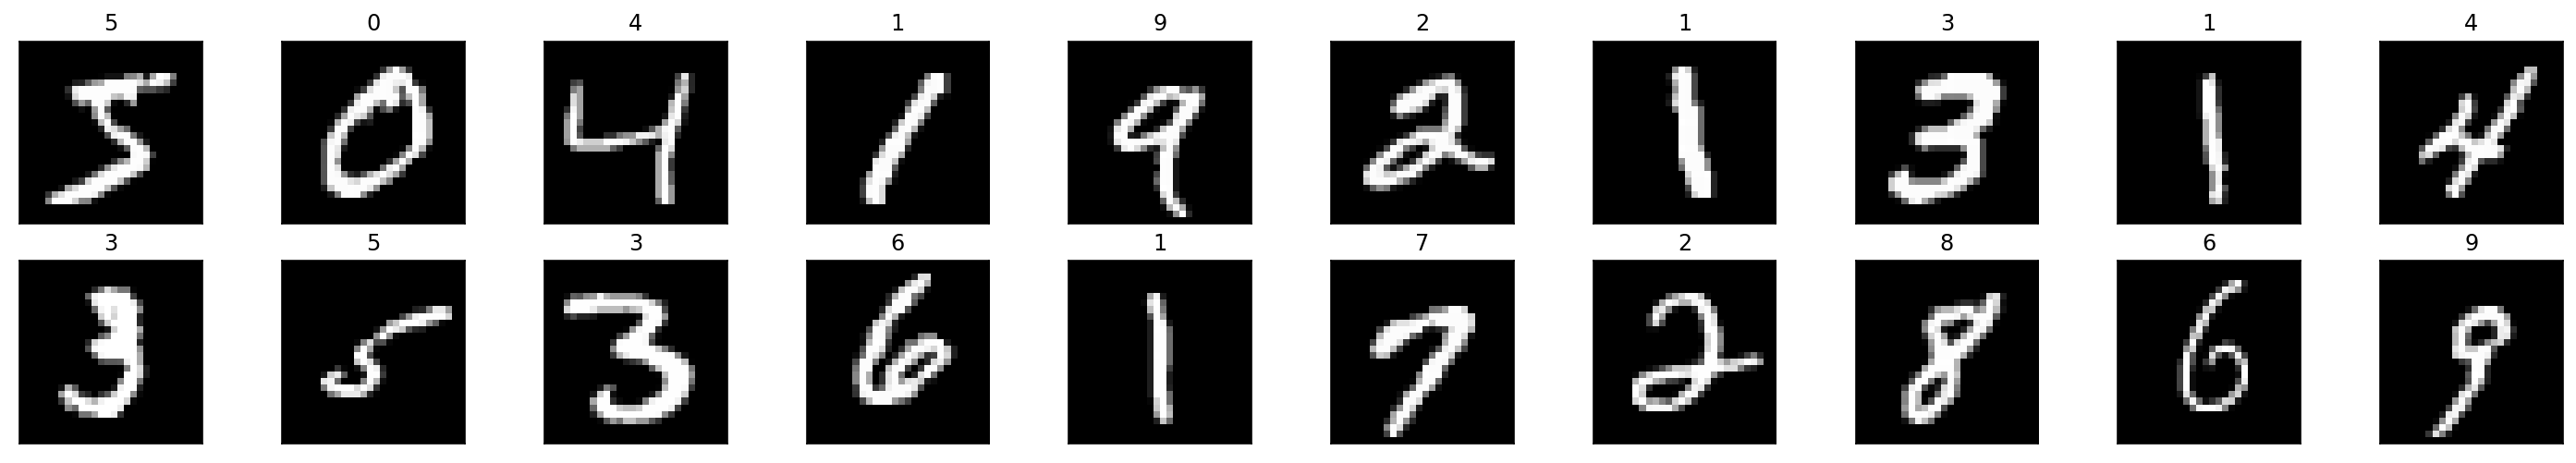

In [3]:
# Visualize a Batch of Training Data
import matplotlib.pyplot as plt
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

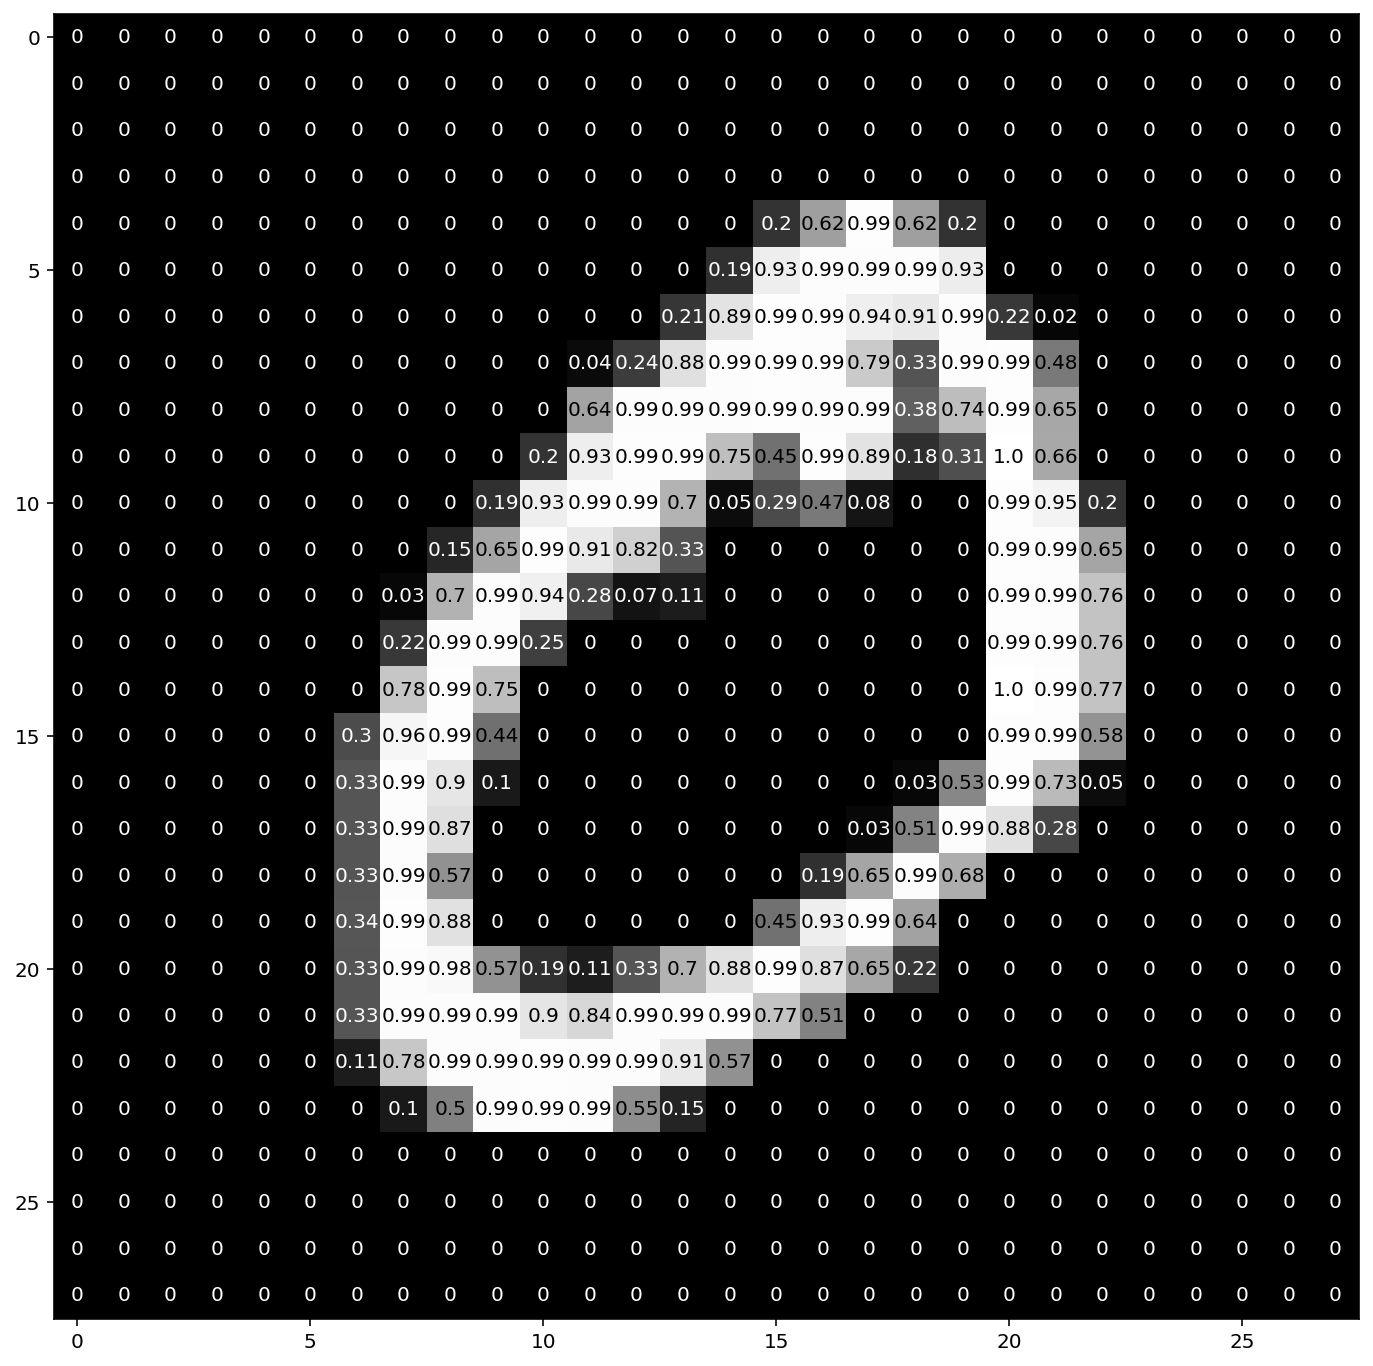

In [4]:
# View an Image in More Detail
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [5]:
# Define the Network Architecture
from torch import nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        # Drop out module with 0.2 drop probability
        self.dropout = nn.Dropout(p = 0.2)
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(-1, 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim = 1)  # Output so no dropout here
        
        return x

# Initialise th NN
model = Network()

In [6]:
# Specify Loss Function and Optimizer
# specify loss function
criterion = nn.NLLLoss()

from torch import optim
# specify optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.001)

In [7]:
# Train the Network

# number of epochs to train the model
n_epochs = 30

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
             
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 2.296236
Epoch: 2 	Training Loss: 2.271553
Epoch: 3 	Training Loss: 2.200540
Epoch: 4 	Training Loss: 1.887662
Epoch: 5 	Training Loss: 1.305051
Epoch: 6 	Training Loss: 0.980938
Epoch: 7 	Training Loss: 0.818054
Epoch: 8 	Training Loss: 0.714027
Epoch: 9 	Training Loss: 0.641597
Epoch: 10 	Training Loss: 0.588904
Epoch: 11 	Training Loss: 0.547878
Epoch: 12 	Training Loss: 0.515951
Epoch: 13 	Training Loss: 0.486919
Epoch: 14 	Training Loss: 0.464290
Epoch: 15 	Training Loss: 0.437155
Epoch: 16 	Training Loss: 0.419584
Epoch: 17 	Training Loss: 0.405650
Epoch: 18 	Training Loss: 0.389225
Epoch: 19 	Training Loss: 0.374572
Epoch: 20 	Training Loss: 0.361425
Epoch: 21 	Training Loss: 0.348781
Epoch: 22 	Training Loss: 0.337671
Epoch: 23 	Training Loss: 0.328138
Epoch: 24 	Training Loss: 0.311263
Epoch: 25 	Training Loss: 0.305127
Epoch: 26 	Training Loss: 0.294568
Epoch: 27 	Training Loss: 0.285764
Epoch: 28 	Training Loss: 0.277710
Epoch: 29 	Training Loss: 0.2

In [9]:
# Test the Trained Network
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.193543

Test Accuracy of     0: 98% (964/980)
Test Accuracy of     1: 98% (1113/1135)
Test Accuracy of     2: 92% (956/1032)
Test Accuracy of     3: 94% (951/1010)
Test Accuracy of     4: 95% (934/982)
Test Accuracy of     5: 90% (811/892)
Test Accuracy of     6: 96% (923/958)
Test Accuracy of     7: 92% (952/1028)
Test Accuracy of     8: 91% (891/974)
Test Accuracy of     9: 91% (925/1009)

Test Accuracy (Overall): 94% (9420/10000)


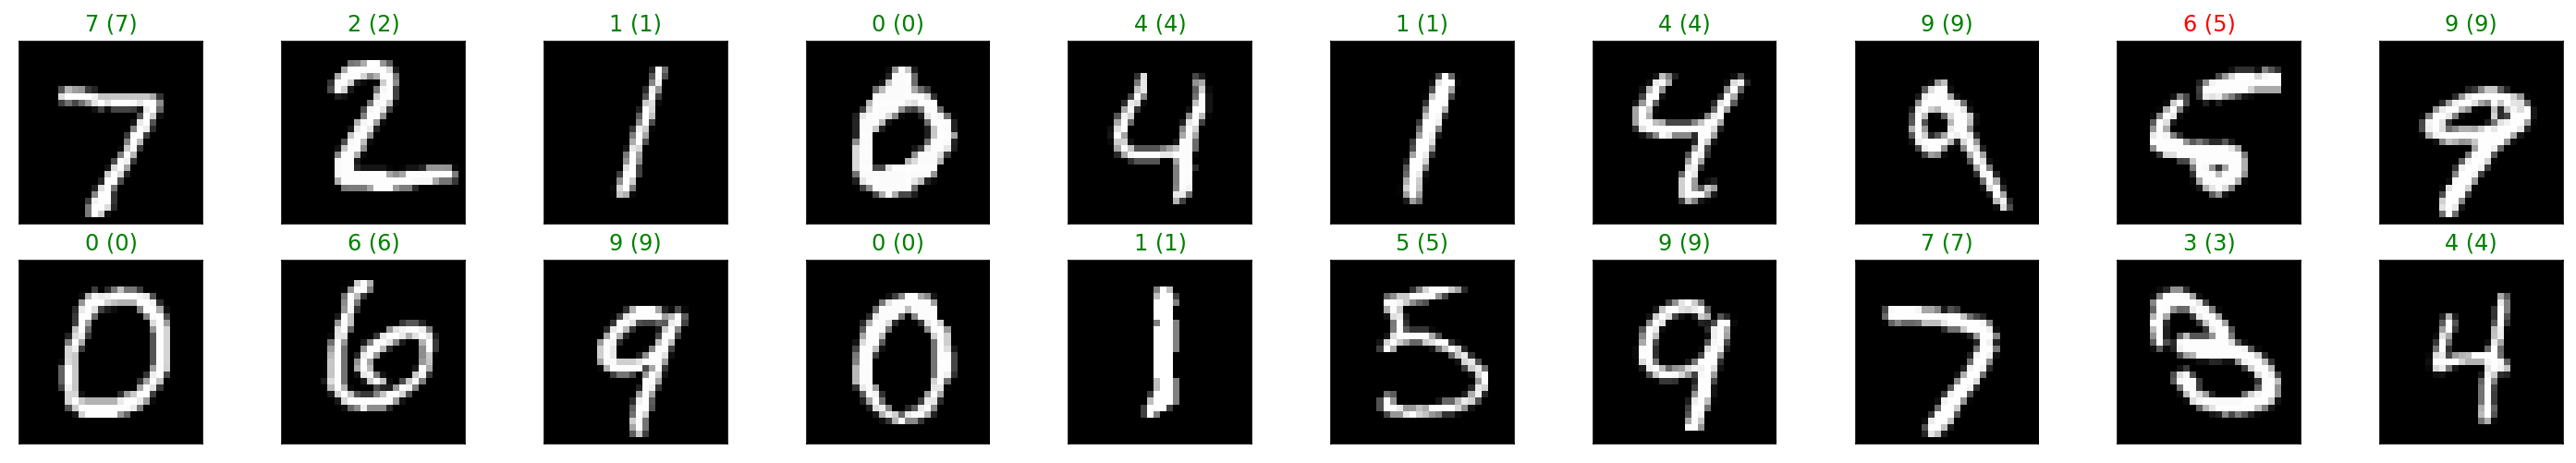

In [10]:
# Visualize Sample Test Results
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))